In [1]:
import multiprocessing as mp
import os
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.eigenstates()
        return groundState[0][0],groundState[1][0]

In [7]:
#Get Ground State Energy and Wavefuntion
class GroundStateNumpy:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        h = H.full()
        e, v = np.linalg.eigh(h) 
        inds = np.argsort(e)
        e = e[inds]
        v = v[:, inds]
        return e[0],v[0]

In [8]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [9]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
    par = 1-2*np.random.rand(2*(N+M+N*M))
    return par

In [10]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [11]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [12]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [13]:
#Conjugate Gradient Descent

class ConGradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
    @timing
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)
        return min, found_gs, found_gsEnergy  

In [14]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [15]:
#Ensures conjugate gradient descent convergance
@timing 
def CgdConvergance(N, M, B, A0):
    eng = 1000
    cgd= 0
    #Run three times
    for i in range(3):
        par = ranRBMpar(N,M)
        conGradDescent = ConGradDescent(N, B, A0)
        cgdTemp = conGradDescent(N, M,par)
        engTemp = cgdTemp[2]
        if(engTemp<eng):
            eng = engTemp
            cgd = cgdTemp
    return cgd

In [16]:
def runDescent(N, M, B, A0):
    par = ranRBMpar(N,M)
    #cgd = CgdConvergance(N, M, B, A0)
    conGradDescent = ConGradDescent(N, B, A0)
    cgd = conGradDescent(N, M,par)
    return cgd

In [17]:
def runExact(N, B, A0):
    groundState = GroundState(N,B,A0)
    ed = groundState()
    groundStateNumpy = GroundStateNumpy(N,B,A0)
    edNumpy = groundStateNumpy()
    return ed, edNumpy

## Run Statistics

In [18]:
# Runs inforamtion is saved at the following locations:
#Data/06-08-20/


In [19]:
# #How to read saved data
# saved = []
# with open('Data/May12/N2M3Bpi.json') as file:
#     for line in file:
#         saved.append(json.loads(line))

# cgdTime,cgdEngErr,cgdStateErr,edTime,len(hisIt)=saved

## Generating Data

In [20]:
#Parameter definition 
B = np.pi
A0 = 1
NList = np.arange(1,12)

edTimeAll = []
edEngAll = []
edStateAll = []
edTimeNumpyAll = []
edEngNumpyAll = []
edStateNumpyAll = []

    

In [22]:
for i in range (len(NList)):
    #exact diagonalization 
    groundState = GroundState(i+2,B,A0)
    ed = groundState()
    edTime = ed[1]
    edTimeAll.append(edTime)
    edEng = ed[0][0]
    edEngAll.append(edEng)
    edState = ed[0][1]
    edStateAll.append(edState)

In [21]:
for i in range (len(NList)):   
    groundStateNumpy = GroundStateNumpy(i+2,B,A0)
    edNumpy = groundStateNumpy()
    edTimeNumpy = edNumpy[1]
    edTimeNumpyAll.append(edTimeNumpy)
    edEngNumpy = edNumpy[0][0]
    edEngNumpyAll.append(edEngNumpy)
    edStateNumpy = edNumpy[0][1]
    edStateNumpyAll.append(edStateNumpy)

<Figure size 432x288 with 0 Axes>

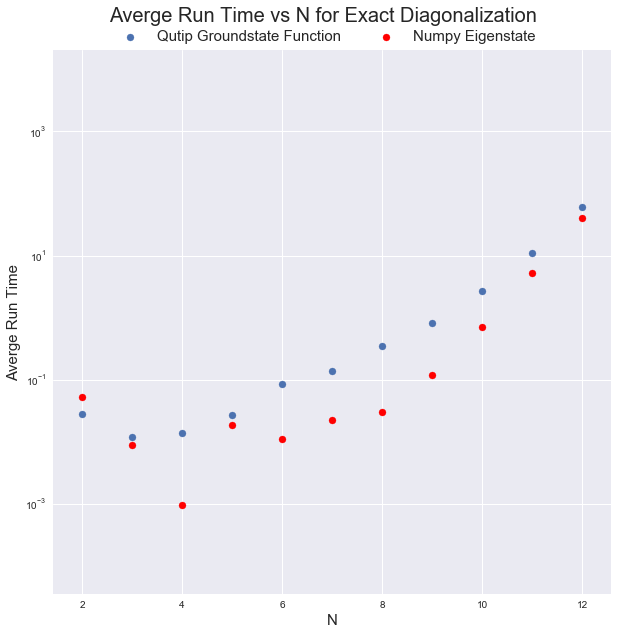

In [26]:

ns = np.arange(2,13)

plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("Averge Run Time vs N for Exact Diagonalization",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.94])


ax4 = plt.subplot(gs[0, :])
ax4.set_yscale('log')
)
#ax4.set_xscale('log')
#ax4.set_ylim([-0.001,0.01])
#ax4.set_xlim([1,10])
ax4.scatter(ns,edTimeAll, label='Qutip Groundstate Function') 
ax4.scatter(ns,edTimeNumpyAll, color = 'red', label= 'Numpy Eigenstate') 

ax4 .set_ylabel("Averge Run Time", size = 15)
ax4.set_xlabel("N",size = 15)
plt.legend(loc = (0.1, 1),fontsize = 15,ncol=2)

In [ ]:
dataLocation = 'Data/06-08-20/ExactTime.json'
saved = []
with open(dataLocation) as file:
    for line in file:
        saved.append(json.loads(line))
print(saved)

In [28]:
#Save data to JSON file
dataLocation = 'Data/06-08-20/ExactTime.json'
data = [edTimeAll,edTimeNumpyAll]
open(dataLocation, "w").close()
with open(dataLocation, 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')   
